In [3]:
# Alright so here we can sort of go back to what we did with
# the antibodies, where we do a sort of autodetection of the
# key anchor points on the target sequence (peptide)
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import rc
import pandas
from time import time

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-14:] != 'AIMS-immunopep':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)
import aims_loader as aimsLoad
import aims_analysis as aims

In [4]:
# DEFINE PLOT PARAMETERS:
font = {'family' : 'Arial',
'weight' : 'bold',
'size'   : 16}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

In [5]:
AA_num_key = aims.get_props()[1]
AA_num_key_new = aims.get_props()[2]
AA_key = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']

In [4]:
# This is a different set of datasets I need to play with...
#dsets = np.array(['Pearson','Giam','Liepe'])
# About the datasets:
# Pearson et al = MHC Class I (HLA-A/B)
# Giam et al = HLA-A1
# Liepe et al = MHC Class I (HLA-A/B)
#pepPath = '/Users/boughterct/Desktop/Immunopep/'
# spliced files
#files = ['GR_LCL_2Dsplice_eth.csv','GR_LCL_2Dnonsplice_eth.csv']
#files = ['Fibro_1Dsplice_hcd.csv','Fibro_1Dnonsplice_hcd.csv']
#files = ['C1R_1Dsplice_eth.csv','C1R_1Dnonsplice_eth.csv']
#files = ['T2_1Dsplice_eth.csv','T2_1Dnonsplice_eth.csv']

# Can't have your labels be redundant... i.e. can't have "Splice" and "NonSplice"
# because then selecting "Splice" will select both...
#label=['isSplice','NonSplice']
#peps1 = aimsLoad.pep_loader(pepPath+files[0],label=label[0])
#peps2 = aimsLoad.pep_loader(pepPath+files[1],label=label[1])

In [8]:
# We need to come up with a specialized section of code for analyzing the webscraped data.
# I can just be unbiased, lump together all data from a couple of different sources.
# Start first with just doing some tissue specific (or species specific) analysis
pepPath = '/Users/boughterct/Desktop/Immunopep/mhcScrape/mhcScrape/meta_files/'
for i in np.arange(23):
    i = i + 1
    if i < 10:
        buff = '0'
    else:
        buff=''
    dat = 'mhc'+buff+str(i)+'_meta.csv'
    x=pandas.read_csv(pepPath+dat,sep=',',header=0)
    if i == 1:
        full_meta = x
    else:
        full_meta = pandas.concat([full_meta,x])

In [72]:
# Here is how we can take out portions of the datasets one by one
# You can select on whichever combinations of things you want
oname = 'Colon'
cell = full_meta[full_meta['Organism'] == 'Human']
organ = cell[cell['TissueType'] == oname]
line = 'HCT116'
subtype = organ[organ['CellType'] == line]
print(np.shape(subtype))
#subtype.to_csv(oname+'_'+line+'.csv')

(1, 7)


In [305]:
# Load back in the files from my very particular data subsets.
pepPath = '/Users/boughterct/Desktop/Immunopep/mhcScrape/mhcScrape/SYSMHC_data/'
metaPath = '/Users/boughterct/Desktop/Immunopep/mhcScrape/mhcScrape/data_subsets/'
d1 = 'Blood_CD4_PBMC'; d2='Blood_PBMC'
d3 = 'Blood_B_lymphoblast'; d4 = 'Blood_B_lymphoblast_cell_line_GR'
#d5 = 'mouse_skin'; d6 = 'mouse_melanoma'
#d7 = 'mouse_thymus'; d8 = 'mouse_lymphoma'

meta1=pandas.read_csv(metaPath+d1+'.csv',sep=',',header=0); meta2=pandas.read_csv(metaPath+d2+'.csv',sep=',',header=0)
meta3=pandas.read_csv(metaPath+d3+'.csv',sep=',',header=0); meta4=pandas.read_csv(metaPath+d4+'.csv',sep=',',header=0)
#meta5=pandas.read_csv(metaPath+d5+'.csv',sep=',',header=0); meta6=pandas.read_csv(metaPath+d6+'.csv',sep=',',header=0)
#meta7=pandas.read_csv(metaPath+d7+'.csv',sep=',',header=0); meta8=pandas.read_csv(metaPath+d8+'.csv',sep=',',header=0)

# It may seem stupid to separate these out just to pull them back in again, but I think it may be cleaner this way
datasets = [d1,d2,d3,d4]#,d5,d6,d7,d8]
metas = pandas.concat([meta1,meta2,meta3,meta4])#,meta5,meta6,meta7,meta8])

In [328]:
final_peptides = []
for i in datasets:
    first = True
    #ss = i.find('mouse_')
    ss = i.find('Blood_')
    tissue =  i[ss+6:]
    # So these are really special, unfortunately.
    # Need to do these when people encode spaces into their titles
    #if tissue == 'Lewis_lung_carcinoma':
     #   t_label = 'Lewis lung carcinoma'
    #elif tissue == 'malignant_glioma':
    #    t_label = 'malignant glioma '
    if tissue == 'CD4_PBMC':
        t_label = 'CD4+ PBMC'
    elif tissue == 'B_lymphoblast':
        t_label = 'B lymphoblast'
    elif tissue == 'B_lymphoblast_cell_line_GR':
        t_label = 'B lymphoblastoid cell line GR'
    else:
        t_label = tissue
    # This needs to be "TissueType" for mice
    sub = metas[metas['CellType'] == t_label]
    for j in np.array(sub['SampleID']):
        if j == 'SYSMHC00018_Schusterh_160204_Rammensee_Germany_B16F10_Y3':
            continue
        elif j == 'SYSMHC00018_carone_160612_Aebersold_Switzerland_LLC2_Y3':
            continue
        elif j == 'SYSMHC00018_carone_160612_Aebersold_Switzerland_GL261_Y3':
            continue
        if first: 
            pepF, alleleF = aimsLoad.pep_loader(pepPath+j+'.csv', label=i,scrape=True)
            first = False
        else:
            start = pepF.columns[-1].find(tissue)
            num = int(pepF.columns[-1][start+len(tissue)+1:])
            pep_hold, allele = aimsLoad.pep_loader(pepPath+j+'.csv', label=i,scrape=True, start_label = num+1)
            pepF = pandas.concat([pepF,pep_hold],axis=1)
            alleleF = pandas.concat([alleleF,allele],axis=1)
    if len(final_peptides) == 0:
        final_peptides = pepF
        final_alleles = alleleF
    else:
        final_peptides = pandas.concat([final_peptides, pepF], axis = 1)
        final_alleles = pandas.concat([final_alleles, alleleF], axis = 1)
final_alleles=np.transpose(final_alleles)

In [330]:
# Alright so this is everything that we've got from blood. Can or cannot choose to further subsect this data...
final_allele_hla = final_alleles[final_alleles[0].str.contains('HLA')]
#blood_classI = allele_bloodF[allele_bloodF[0].str.contains('class I')][allele_bloodF[0] != 'class II']
#blood_classII = allele_bloodF[allele_bloodF[0].str.contains('class II')]
#blood_unknown = allele_bloodF[allele_bloodF[0] == 'unclassified']

# And then this works to select those subsets (what a painful process)
final_peptides_hla = final_peptides[np.array(final_allele_hla.index)]
#pep_classI_blood = pep_blood[np.array(blood_classI.index)]
#pep_classII_blood = pep_blood[np.array(blood_classII.index)]
#pep_unknown_blood = pep_blood[np.array(blood_unknown.index)]

In [305]:
# Pick out only very particular HLAs
#pep_A01_blood = pep_blood[blood_HLA_known[blood_HLA_known[0].str.contains('HLA-A01:01')].index]
#pep_A01_blood.to_csv('Blood_HLA-A01.csv')

In [324]:
label = datasets
mouse = False
hla_count_concat = []
for dset in np.arange(len(label)):
    multi_count = 0
    first = True
    index = [column for column in final_alleles.columns if label[dset] in column]
    sub_dset = np.transpose(final_alleles[index])
    for i in np.array(sub_dset.drop_duplicates()):
        # So I'm pretty sure that every dataset separates multiple alleles
        # by this ";"... The nice thing with mouse data is that they
        # know EXACTLY which HLA allele it is.
        if i[0].find(';') != -1:
            multi_count += 1
        else:
            hla_count = len(np.array(sub_dset[sub_dset[0] == i[0]]))
            hla_label = i[0]
            # So I need to bring these back at some point. Some way to
            # filter out datasets with MANY different HLAs.
            #if hla_count < 2500:
             #   if first_lowFreq:
              #      hla_countLow = hla_count
               #     hla_labelLow = hla_label[4:]
                #    first_lowFreq = False
                #else:
                 #   hla_countLow = np.hstack((hla_countLow, hla_count))
                  #  hla_labelLow = np.hstack((hla_labelLow, hla_label[4:]))
                #continue
            # this is a space saving trick on the figure,
            # but you don't need to do it for mouse data
            if mouse:
                hla_start = 0
            else:
                hla_start = 4

            if first:
                hla_countF = hla_count
                hla_labelF = hla_label[hla_start:]
                first = False
            else:
                hla_countF = np.hstack((hla_countF, hla_count))
                hla_labelF = np.hstack((hla_labelF, hla_label[hla_start:]))
    if len(hla_count_concat) == 0:
        hla_count_concat = hla_countF
        hla_label_concat = hla_labelF
        multi_concat = multi_count
    else:
        # Alright so this works for now, but unsure if it will for more complicated human
        # data... Mouse data is just far too easy to work with (only ever 2 alleles)
        hla_count_concat = np.vstack((hla_count_concat, hla_countF))
        hla_label_concat = np.vstack((hla_label_concat, hla_labelF))
        multi_concat = np.vstack((multi_concat, multi_count))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 18 and the array at index 1 has size 31

In [326]:
final_peptides

Blood_CD4_PBMC_0 Blood_CD4_PBMC_1 Blood_CD4_PBMC_2 Blood_CD4_PBMC_3  \
0     AESEEGPDVLRW     GEIDGNKVTLDW        VLLQKVLLY         TEVTGHRW   

  Blood_CD4_PBMC_4 Blood_CD4_PBMC_5 Blood_CD4_PBMC_6 Blood_CD4_PBMC_7  \
0     AEDALHNLDRKW      AEQELANLEKW        MENGIVRNW        VLLDYHLNY   

  Blood_CD4_PBMC_8 Blood_CD4_PBMC_9  ...  \
0       EEIDLRSVGW       SEAGSHTLQW  ...   

  Blood_B_lymphoblast_cell_line_GR_40410  \
0                             VRFNVLKVTK   

  Blood_B_lymphoblast_cell_line_GR_40411  \
0                            VRLLLPGELAK   

  Blood_B_lymphoblast_cell_line_GR_40412  \
0                           VRLLLPGELAKH   

  Blood_B_lymphoblast_cell_line_GR_40413  \
0                            VRMNVLADALK   

  Blood_B_lymphoblast_cell_line_GR_40414  \
0                             VRNGYGFINR   

  Blood_B_lymphoblast_cell_line_GR_40415  \
0                             VRVKLVSAGF   

  Blood_B_lymphoblast_cell_line_GR_40416  \
0                              VVYPWTQRF   

  Blood_B_lymphoblast_cell_line_GR_40417  \
0                              YAFPKAVSV   

  Blood_B_lymphoblast_cell_line_GR_40418  \
0                           YGYNQRPPYGYY   

  Blood_B_lymphoblast_cell_line_GR_40419  
0                              YQFTGIKKY  

[1 rows x 264574 columns]

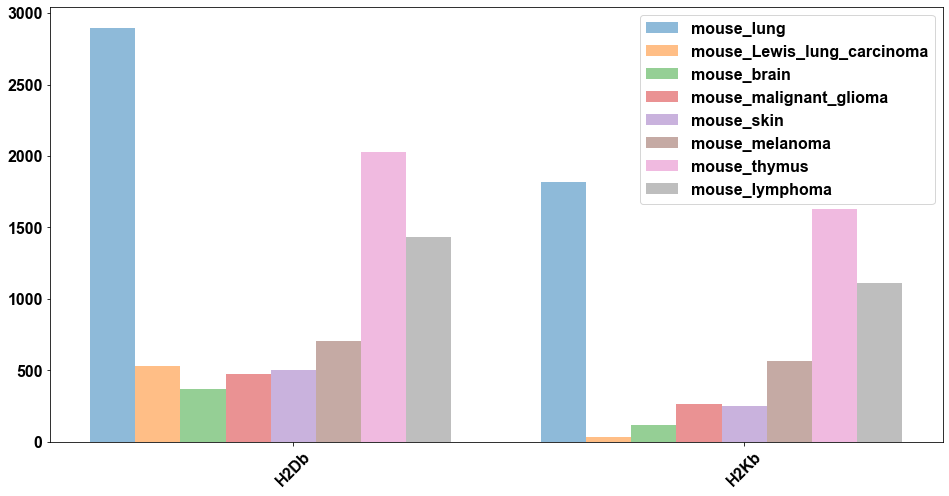

In [258]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
# This needs to get a LOT more creative once we deal with human data
x_axis = [0,1.25]
for i in np.arange(len(label)):
    ax[0,0].bar(x_axis+i*1/len(label) ,hla_count_concat[i],alpha = 0.5,width = 1/len(label))
    #ax[0,0].bar([len(hla_count_concat[i])+1], [multi_concat])
    # Add in a creative way to deal with different HLAs here:
xax=pl.setp(ax[0,0],xticks=x_axis + np.array(0.5),xticklabels=hla_label_concat[i])
hh = pl.xticks(rotation=45)
pl.legend(label)

Text(0, 0.5, 'Peptide ID')

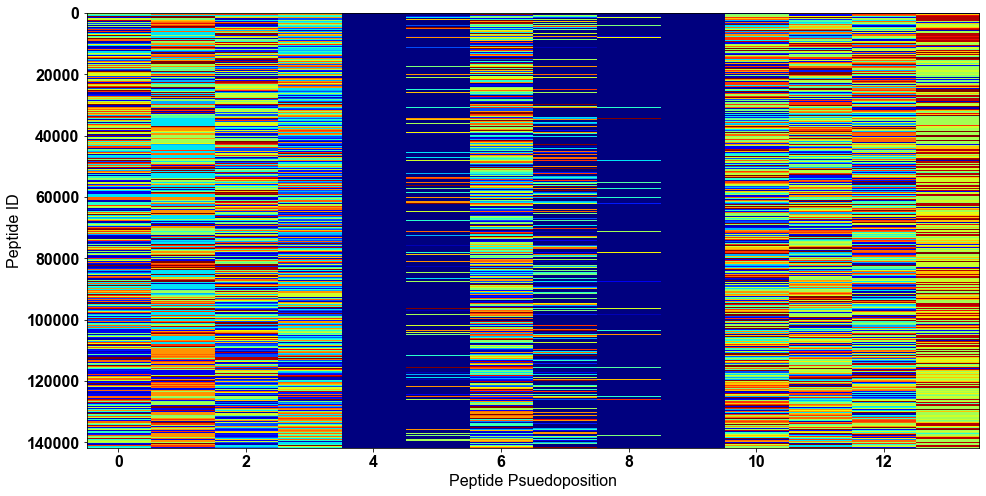

In [332]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
seq_MI = aims.gen_peptide_matrix(np.array(final_peptides_hla),key = AA_num_key,binary = False)
seq_MIf = pandas.DataFrame(np.transpose(seq_MI),columns = final_peptides_hla.columns)

pl.imshow(np.array(np.transpose(seq_MIf)),interpolation='nearest', aspect='auto',cmap=cm.jet)
pl.xlabel('Peptide Psuedoposition')
pl.ylabel('Peptide ID')
#fig.savefig('C1R_mat.pdf',format='pdf',dpi=500)

Text(0, 0.5, 'Normalized Property Value')

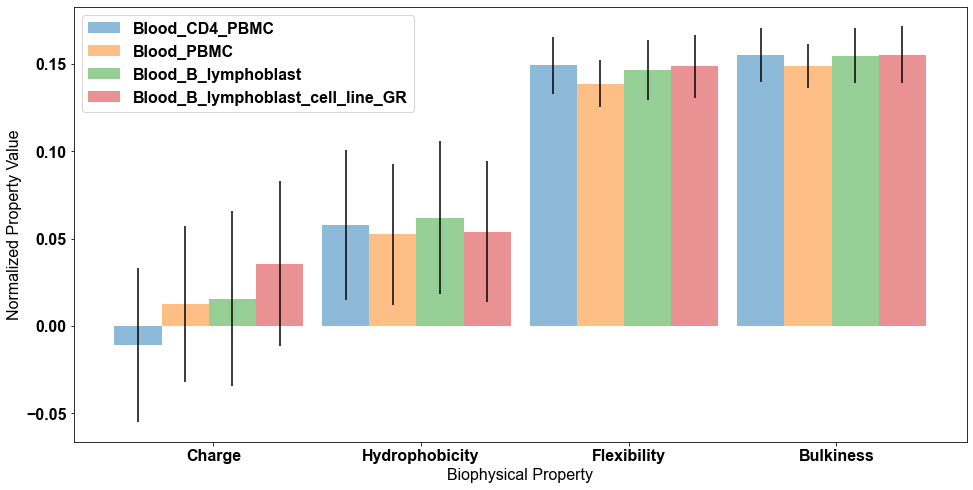

In [333]:
pca_props = aims.gen_clone_props(np.array(np.transpose(seq_MIf)))
pcaF = pandas.DataFrame(pca_props,columns = seq_MIf.columns)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x_axis = np.array([-0.2,0.9,2,3.1])
# Need to have some kind of color wheel to replace this...
#colors = ['purple','green','black','orange']
for i in np.arange(len(label)):
    index = [column for column in pcaF.columns if label[i] in column]
    plotThis = np.array(pcaF[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    ax[0,0].bar(x_axis+i*1/len(label), np.average(plotThis[1:5,:],axis = 1),
                yerr = np.std(plotThis[1:5,:],axis = 1),alpha = 0.5, width = 1/len(label))
ax[0,0].legend(label)
ax[0,0].set_xticks([0.2,1.3,2.4,3.5])
ax[0,0].set_xticklabels(['Charge','Hydrophobicity','Flexibility','Bulkiness'])
ax[0,0].set_xlabel('Biophysical Property')
ax[0,0].set_ylabel('Normalized Property Value')
#fig.savefig('bloodVskin_properties.pdf',format='pdf',dpi=500)

[0.16919815 0.14366988 0.11725078]


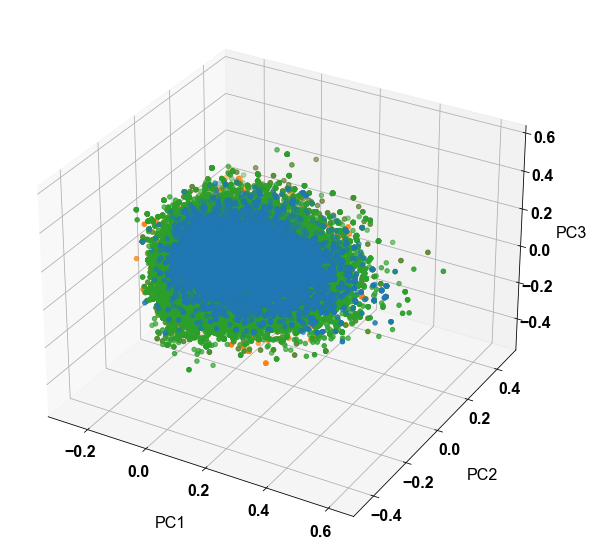

In [334]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='full')
final=pca.fit_transform(np.transpose(pca_props))
#seq_PCA = aims.gen_tcr_matrix(np.array(seq_final),key = AA_num_key, giveSize = mat_size)
#final = pca.fit_transform(seq_PCA)
print(pca.explained_variance_ratio_)

from mpl_toolkits import mplot3d
fig3d = pl.figure(figsize = (10, 10))
ax3d = fig3d.add_subplot(111, projection='3d')

# Alright plot this in an intelligent way
transform_pca = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)
for i in np.arange(len(label)):
    index = [column for column in transform_pca.columns if label[i] in column]
    plotThis = np.array(transform_pca[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    ax3d.scatter(plotThis[0], plotThis[1], plotThis[2])

ax3d.set_xlabel('PC1',labelpad=20)
ax3d.set_ylabel('PC2',labelpad=20)
ax3d.set_zlabel('PC3',labelpad=10)
#pl.savefig('PCA_parsedata_3D.pdf',DPI=500,format='pdf')
pl.show()

Text(0, 0.5, 'PC2')

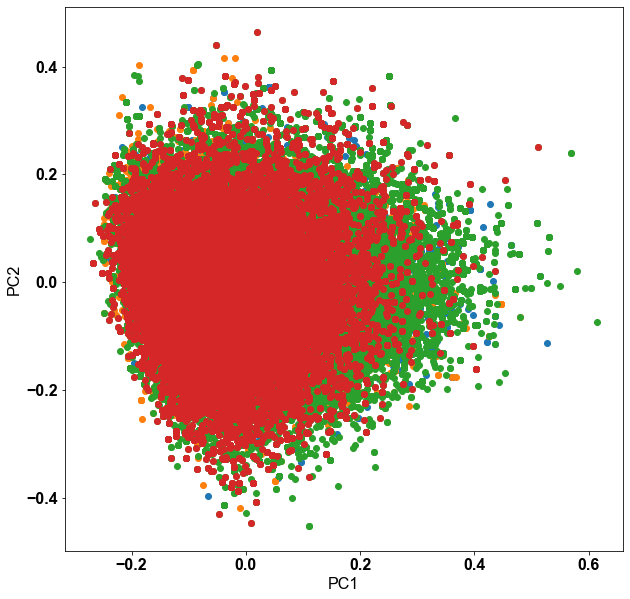

In [335]:
fig = pl.figure(figsize = (10, 10))
for i in np.arange(len(label)):
    #if i == 2:
    #    continue
    index = [column for column in transform_pca.columns if label[i] in column]
    plotThis = np.array(transform_pca[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    pl.scatter(plotThis[0], plotThis[1])
    
pl.xlabel('PC1')
pl.ylabel('PC2')
#pl.savefig('PCA_2Dparse.pdf',DPI=500,format='pdf')

# As a Heads Up, AIMS_bootstrap works well, so maybe incorporate some of that multiprocessing here

38.51020353060297
36.80045926579413
38.72288773735769
38.02871898349408


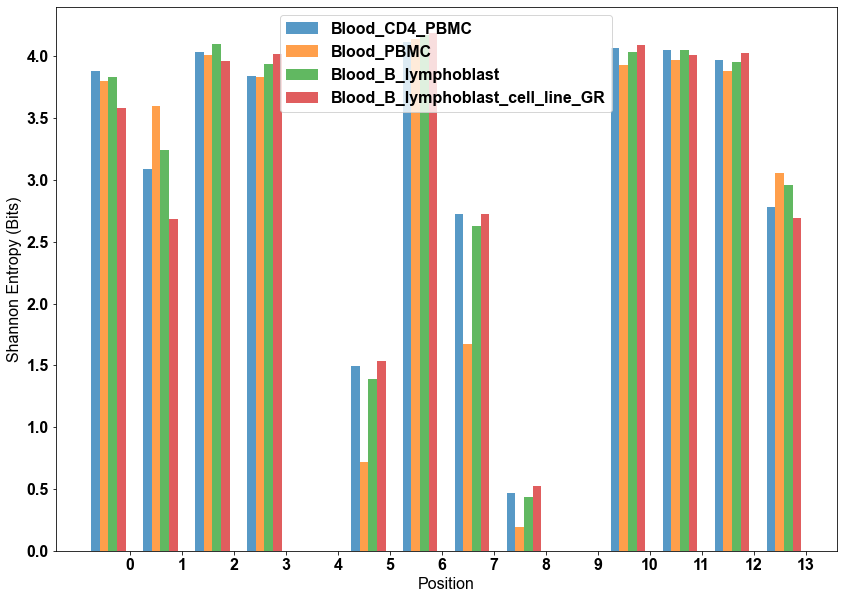

In [336]:
# There's no reason to not add the information theory stuff, even if it isn't in the app yet
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
seq_len = len(seq_MIf)
# Alright let's save our amino acid frequencies.
# Might be interesting, particularly for different MHCs
frequencies = np.zeros((len(label),seq_len,21))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
    entropy, AA_count=aims.calculate_shannon(np.transpose(subset))

    frequencies[i] = AA_count
    pl.bar(np.arange(len(entropy))*1.5+i*1/len(label),entropy,width=1/len(label), alpha = 0.75)
    print(sum(entropy))
    
pl.legend(label)
pl.xlabel('Position')
pl.ylabel('Shannon Entropy (Bits)')
x1 = ax[0,0].set_xticks(np.arange(len(entropy))*1.5 + 1/len(label)*4)
x2 = ax[0,0].set_xticklabels(np.arange(len(entropy)))
#fig.savefig('bloodVskin_shannon.pdf',format='pdf',dpi=500)

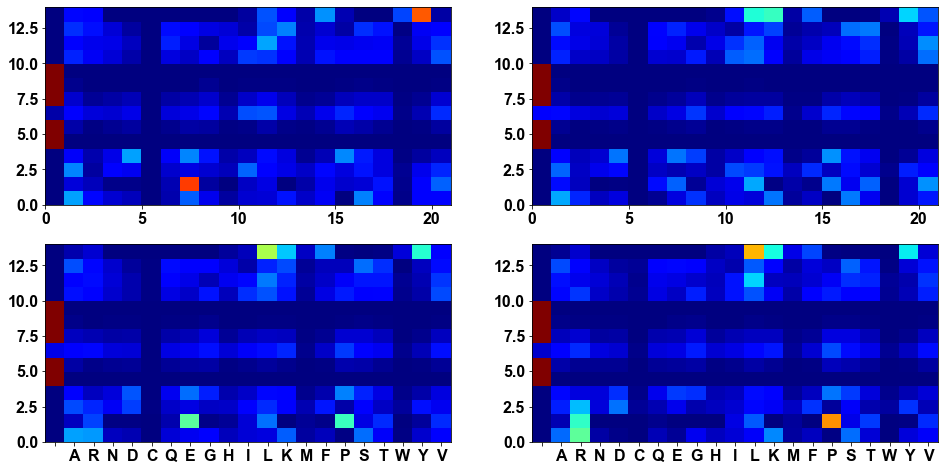

In [339]:
fig, ax = pl.subplots(int(len(label)/2), 2,squeeze=False,figsize=(16,8))
a = 0; b = 0
for i in np.arange(len(label)):
    x=ax[a,b].pcolormesh(frequencies[i],vmin=0,vmax=0.5,cmap=cm.jet)
    if b == 1:
        b = 0
        a += 1
    else:
        b += 1
    
#pl.colorbar(x)
#pl.title('Amino Acid Frequency Difference')
#pl.xlabel('Amino Acid')
#pl.ylabel('Position')
xax=pl.setp(ax[1,0],xticks=np.arange(21)+0.5,xticklabels=[' ']+AA_key)
xax=pl.setp(ax[1,1],xticks=np.arange(21)+0.5,xticklabels=[' ']+AA_key)
#pl.savefig('BloodMinusSkin_AAprob.pdf', format='pdf')# dpi=1000)

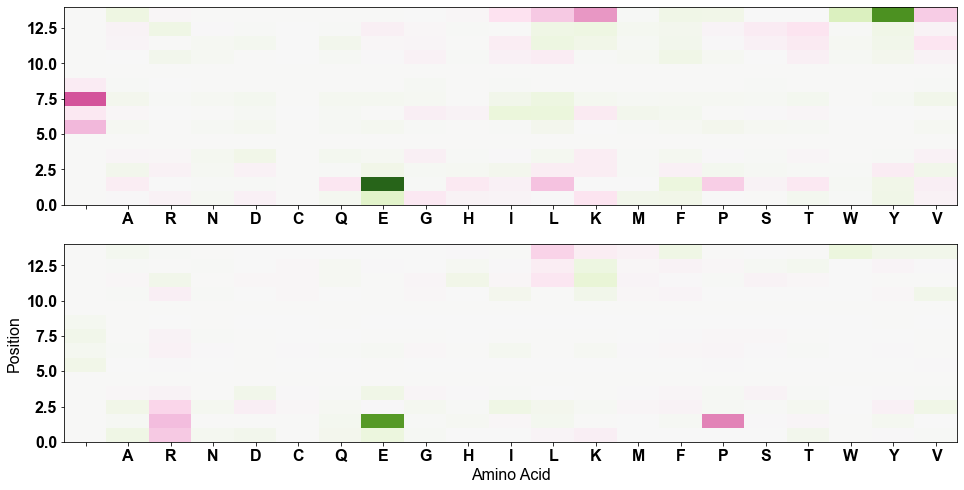

In [340]:
fig, ax = pl.subplots(int(len(label)/2), 1,squeeze=False,figsize=(16,8))
for i in np.arange(0,len(label),2):
    x=ax[int(i/2),0].pcolormesh(frequencies[i]-frequencies[i+1],vmin=-0.3,vmax=0.3,cmap=cm.PiYG)
#pl.colorbar(x)
pl.xlabel('Amino Acid')
pl.ylabel('Position')
xax=pl.setp(ax,xticks=np.arange(21)+0.5,xticklabels=[' ']+AA_key)
#pl.savefig('BloodMinusSkin_AAprob.pdf', format='pdf')# dpi=1000)

# We're going to work on calculating digram (and maybe trigram?) structure of these peptides
Take the approach that Claude Shannon originally did. See if anything interesting pops out

Text(0.5, 0, 'Amino Acid')

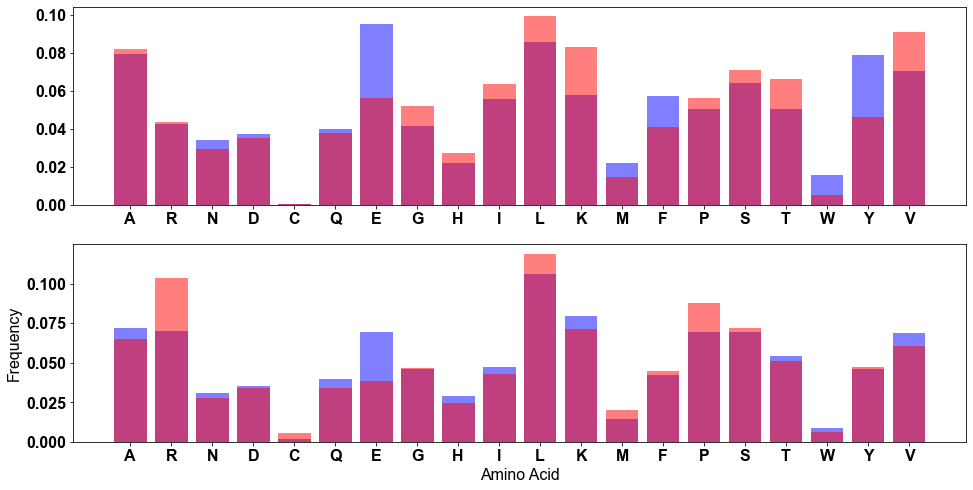

In [341]:
# Pull apart the shannon entropy script, because this is how we calculated AA probabilities
# Original script has position sensitivity, so we now DONT want that.
AA_freq_all = np.zeros((len(label),21))
digram_all = np.zeros((len(label),21,21))
a = 0; b = 0
for dset in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[dset] in column]
    subset = np.transpose(np.array(seq_MIf[index]))
    clones,aas = np.shape(subset)
    AAs = np.arange(0,21)
    
    prob_poly_full=np.zeros((clones,21))
    prob_di_full = np.zeros((clones,21,21))
    for i in np.arange(clones):
        # we need to get back out how long our peptides are...
        space = 0
        digrams = 0
        for j in np.arange((aas)):
            # This is here so we can skip "space"
            if subset[i, j] == 0:
                space += 1
                continue
            for k in AAs:
                if subset[i, j]==k:
                    # Very simple count of the number of times we see an AA
                    prob_poly_full[i, k]=prob_poly_full[i, k]+1
                    # Find our digram frequencies
                    if j == aas-1:
                        # obviously can't get the digram of the last entry
                        # I guess technically you can... but for now, don't
                        continue
                    for di_pair in AAs:
                        # need to do this in order to ignore the spaces
                        if subset[i, j+1] != 0:
                            secAA = subset[i, j+1]
                        elif subset[i, j+2] != 0:
                            secAA = subset[i, j+2]
                        elif subset[i, j+3] != 0:
                            secAA = subset[i, j+3]

                        if secAA == di_pair:
                            prob_di_full[i, k, di_pair] = prob_di_full[i, k, di_pair] + 1
                            digrams += 1
                            break
                    # break out of location (i, j) so we can save a tiny bit of time
                    break
        # renormalize this clone by the length of the peptide
        prob_di_full[i] = prob_di_full[i]/digrams
        prob_poly_full[i] = prob_poly_full[i]/(aas-space)
    # Since we are no longer looking at position sensitive probabilities,
    # we need to also divide by the number of positions (also 14)
    AA_freq_all[dset]=np.sum(prob_poly_full,axis=0)/clones
    digram_all[dset] = np.sum(prob_di_full,axis=0)/clones

fig, ax = pl.subplots(int(len(label)/2), 1,squeeze=False,figsize=(16,8))
for i in np.arange(0,len(label),2):
    ax[int(i/2),0].bar(np.arange(len(AA_freq_all[i,1:])),AA_freq_all[i,1:], color='blue',alpha=0.5)
    ax[int(i/2),0].bar(np.arange(len(AA_freq_all[i+1,1:])),AA_freq_all[i+1,1:],color='red',alpha=0.5)
xax=pl.setp(ax,xticks=np.arange(20),xticklabels=AA_key)
#pl.legend(label)
pl.ylabel('Frequency')
pl.xlabel('Amino Acid')

#shannon_poly=np.zeros(len(poly_count))
#for i in np.arange(len(poly_count)):
 #   for j in np.arange(len(poly_count[0])):
#        if poly_count[i,j]==0:
#            continue
#        shannon_poly[i]=shannon_poly[i]+(-poly_count[i,j]*math.log(poly_count[i,j],2))
#return(shannon_poly,poly_count)

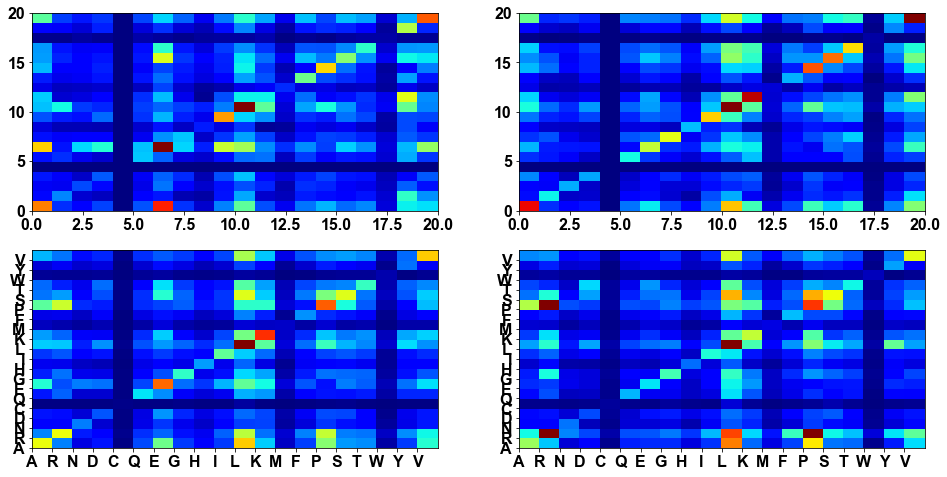

In [342]:
fig, ax = pl.subplots(int(len(label)/2), 2,squeeze=False,figsize=(16,8))
a = 0; b = 0
for i in np.arange(len(label)):
    ax[a,b].pcolormesh(digram_all[i,1:,1:], vmin = 0, vmax = 0.015, cmap = cm.jet)
    if b == 1:
        a += 1
        b = 0
    else:
        b += 1

xax=pl.setp(ax[a-1,0],xticks=np.arange(20),xticklabels=AA_key)
yax=pl.setp(ax[a-1,0],yticks=np.arange(20),yticklabels=AA_key)
xax=pl.setp(ax[a-1,1],xticks=np.arange(20),xticklabels=AA_key)
yax=pl.setp(ax[a-1,1],yticks=np.arange(20),yticklabels=AA_key)
#ax[0,0].set_title('Skin Peptide Digram Structure')
#ax[0,1].set_title('Blood Peptide Digram Structure')

#ax[0,0].set_ylabel('First Amino Acid')
#ax[0,1].set_ylabel('First Amino Acid')
#ax[0,0].set_xlabel('Second Amino Acid')
#ax[0,1].set_xlabel('Second Amino Acid')

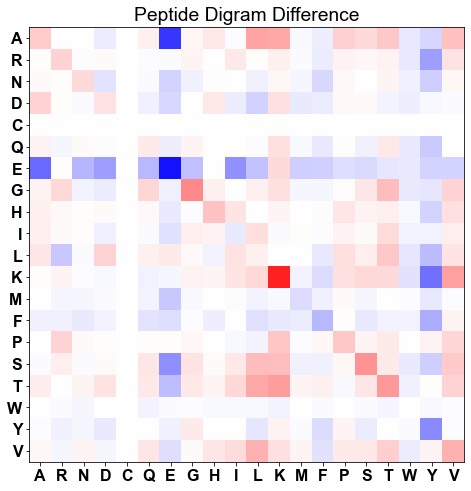

In [343]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
pl.title('Peptide Digram Difference')
pl.imshow(digram_all[1,1:,1:]-digram_all[0,1:,1:], vmin = -0.01, vmax = 0.01, cmap = cm.bwr)
xax=pl.setp(ax,xticks=np.arange(20),xticklabels=AA_key)
yax=pl.setp(ax,yticks=np.arange(20),yticklabels=AA_key)

Text(0.5, 1.0, 'peptides2')

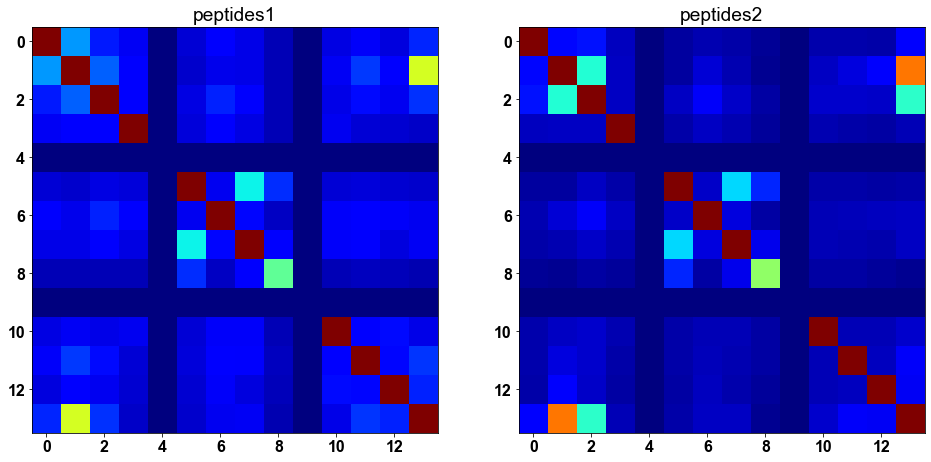

In [344]:
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(16,8))

# So remember, these are here so that we can adapt our scripts to have multiple
# different groups. Adaptatable code is key!
MI_all = np.zeros((len(label),seq_len,seq_len))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
    MI_data, poly_count_cond, counted_data=aims.calculate_MI(np.transpose(subset))
    if label[i] == label[0]:
        ax[0,0].imshow(MI_data,vmin=0,vmax=1.0,cmap=cm.jet)
    else:
        ax[0,1].imshow(MI_data,vmin=0,vmax=1.0,cmap=cm.jet)
    MI_all[i]=MI_data
    
ax[0,0].set_title('peptides1')
ax[0,1].set_title('peptides2')

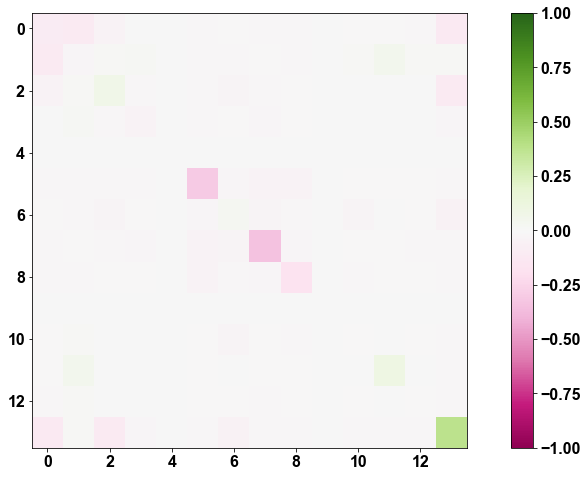

In [93]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x=pl.imshow(MI_all[1]-MI_all[0],vmin=-1.0,vmax=1.0,cmap=cm.PiYG)
pl.colorbar(x)

Text(0, 0.5, 'Normalized Hydrophobicity')

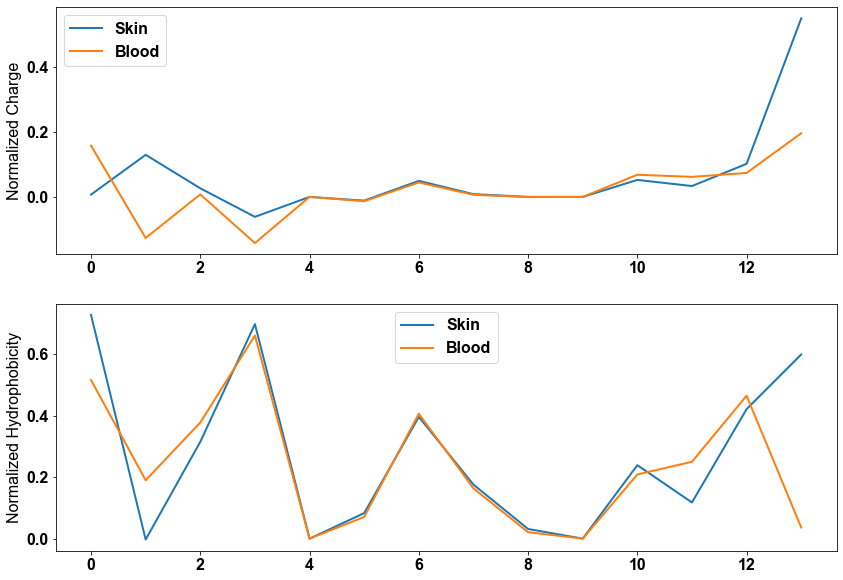

In [94]:
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(14,10))
a = 0
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
   
    pos_sens =aims.gen_dset_props(np.array(np.transpose(subset)),stdev=False)
    # Temporary simple fix to save this data after I run this code
    if a == 0:
        pos_sens1=pos_sens
        a=a+1
    else:
        pos_sens2=pos_sens
    
    for prop in np.arange(2):
        if prop == 0:
            x = 0; y = 0
        elif prop == 1:
            x = 1; y = 0
        plotThis = pos_sens[prop+2]
        #error = dat_stdev[prop+2]
        ax[x,y].plot(np.arange(len(plotThis)), plotThis,linewidth=2.0)
        #ax[x,y].fill_between(np.arange(len(plotThis)),plotThis+error,plotThis-error,color='grey',alpha=0.2)

ax[0,0].legend(label)
ax[1,0].legend(label)

ax[0,0].set_ylabel('Normalized Charge')
ax[1,0].set_ylabel('Normalized Hydrophobicity')

#fig.savefig('c1r_properties.pdf',format='pdf',dpi=500)

0.7798507462686567


<AxesSubplot:xlabel='Dataset', ylabel='Linear Discriminant 1'>

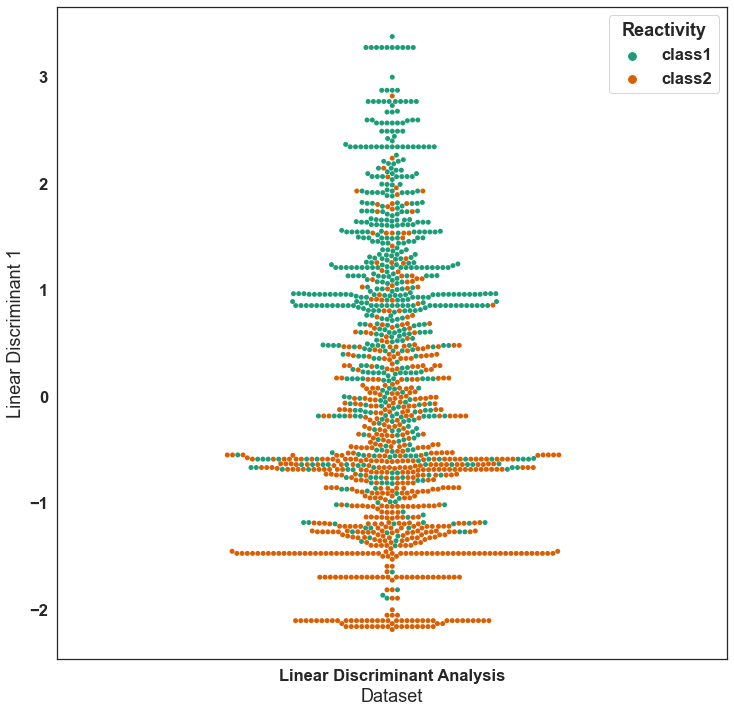

In [12]:
numVects = 10
# Here we also need to get a pre-defined matrix size...
import aims_classification as classy
seq_len = len(seq_MIf)
# Need to split this data into two classes
# We (in the tutorials) have these labels:
#['cd1', 'HLA-A', 'UFA', 'UAA', 'UDA']
# So let's split these up into the below classes:
class_assign = [1,2,0,0,0]
# Here we have 1 = class 1, 2 = class 2, and we'll keep 0 as "unassigned"

class0 = []
class1 = []
class2 = []
for i in np.arange(len(label)):    
    index = [column for column in seq_final.columns if label[i] in column]
    subset = seq_final[index]
   
    if class_assign[i] == 0:
        if len(class0) == 0:
            class0 = subset
        else:
            class0 = np.hstack((class0,subset))
    elif class_assign[i] == 1:
        if len(class1) == 0:
            class1 = subset
        else:
            class1 = np.hstack((class1,subset))
    elif class_assign[i] == 2:
        if len(class2) == 0:
            class2 = subset
        else:
            class2 = np.hstack((class2,subset))

pg1 = class1.values
pg2 = class2.values

num1 = np.shape(pg1)[1]
num2 = np.shape(pg2)[1]
#pg2 = seq2.values
x,y = aims.gen_peptide_matrix(pg1,pre_pep2=pg2,binary=True)
acc_all,weights,cols,indices,mda_all,did_drop = classy.do_linear_split(pg1, pg2, 
ridCorr = True, matSize = numVects, special = 'peptide')
# Seaborn plots look nicer for these LDA figures
import seaborn as sns
fig = pl.figure(figsize = (12, 12))
dset = ["Linear Discriminant Analysis" for x in range(num1+num2)]
reacts = ["class1" for x in range(num1)] + ["class2" for x in range(num2)]

d1 = {'Dataset': dset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
    'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
print(acc_all)
sns.set(style="white", color_codes=True,font_scale=1.5)
sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")

# We defined "class 1" and "classs 2" in the code block above, so just run with that

In [9]:
# We defined "class 1" and "classs 2" in the code block above, so just run with that

num_1 = np.shape(class1)[1]
num_2 = np.shape(class2)[1]
# Be careful not to overfit!!!
numVects = 10

# In the "original" classifier we use a max differences algorithm to reduce dimensionality
# This allows for a direct identification of vectors used for classification (parsed below)
# "SPECIAL" option does end alignment, not having that does center alignment
acc_all,weights,cols,indices,mda_all,did_drop = classy.do_linear_split(class1,class2, matSize = numVects, special= 'peptide')

# For the reviewers, do a PCA split to reduce dimensionality
#acc_all,mda_all = classy.do_linear_split(parse_mono,parse_poly,giveSize = MatrixSize,matSize = numVects,pca_split=True)

# Print out the accuracy
print(acc_all)

0.7798507462686567


These printed propery names should be the x-axis lables (in order):
['Charge', 'Hot21', 'Kid1', 'Hot11', 'Hot36', 'Hot6', 'Hot24', 'Phobic1', 'Hot25']


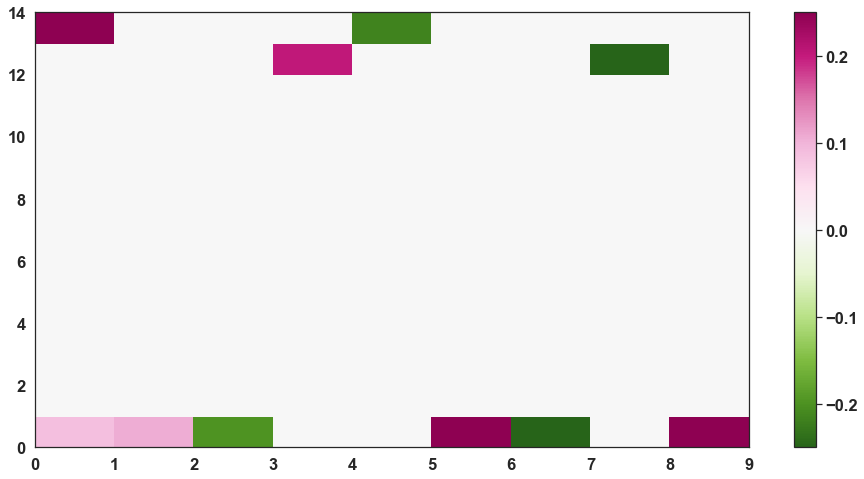

In [13]:
# A lot of code here, but the end goal is to print out both the 
# names and the locations of the top properties used to
# generate the LD1
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
# How many properties do you want to show?
# Make sure this isn't larger than "NumVects"
numTop = numVects
# Get the column headings:
col_heads = cols[indices]
norm_weights=weights/np.linalg.norm(weights)
# Put them into a vector
cdr_loc = [int(i.split('-')[1]) for i in col_heads]
prop = [i.split('-')[0] for i in col_heads]
# Take the outputs from do_linear_split and prepare them for analysis
a1 = np.transpose(np.vstack((cdr_loc,prop,abs(norm_weights[0]))))
a2 = np.transpose(np.vstack((cdr_loc,prop,norm_weights[0])))
x = a2[a1[:,2].argsort()]
# x is sorted backwards, hence the "-numTop"
prop10 = x[-numTop:,1]
cdr10 = [int(a) for a in x[-numTop:,0]]
diff10 = [float(a) for a in x[-numTop:,2]]
a = 0
for i in np.arange(len(prop10)):
    uniq = True
    if i == 0:
        prop_numeric = 1
        uniq_prop_label = [prop10[i]]
        a = a + 1
    else:
        for j in uniq_prop_label:
            if prop10[i] == j:
                uniq =  False
                spot = np.where(prop10==j)[0][0]
                a_old = prop_numeric[spot]
                
    if uniq and i != 0:
        prop_numeric = np.vstack((prop_numeric,1+a))
        uniq_prop_label = np.vstack((uniq_prop_label,prop10[i]))
        a = a+1
    elif i != 0:
        prop_numeric = np.vstack((prop_numeric,a_old))
prop_num2 = [a[0] for a in prop_numeric]
prop_label2 = [a[0] for a in uniq_prop_label]

diff_mat = np.zeros((max(prop_num2),seq_len))
for i in np.arange(numTop):
    x_pos = prop_num2[i]-1
    y_pos = cdr10[i]-1
    diff_mat[x_pos,y_pos] = diff_mat[x_pos,y_pos] + diff10[i]

# NOTE: THE ORDER DID CHANGE COMPARED TO THE PAPER, BUT THE DATA IS IDENTICAL
xx=ax[0,0].pcolormesh(np.transpose(diff_mat),vmin = -0.25, vmax = 0.25, cmap=cm.PiYG_r)
pl.colorbar(xx)
print('These printed propery names should be the x-axis lables (in order):')
print(prop_label2)
#pl.savefig('hiv_75mat.pdf',format='pdf')

# Now get into the actual classification side of things.

In [14]:
# I actually run LOO on a supercomputer. Check "parallel_classification" script
# NOTE: LOO IS INCREDIBLY SLOW (since you have to re-do the analysis over and over)
# options loo, strat_kfold, kfold
meth = 'strat_kfold'
# options max_diff, PCA, kPCA, kbest, none
featurer = 'max_diff'
# options mda, svm, forest, logReg
clf = 'svm'
num_vects =10

# Shuffle the sequences to get "negative control"
#stack = np.transpose(np.hstack((class1, class2)))
#np.random.shuffle(stack)
#shuff_mono = np.transpose(stack)[:,0:num_1]
#shuff_poly = np.transpose(stack)[:,num_1:num_2+num_1]

acc_out = classy.do_classy_mda(class1, class2, matsize = num_vects, xVal = meth, ridCorr = True, 
                               feat_sel = featurer, classif = clf, special= 'peptide')
print(acc_out)

[[0.75373134]
 [0.76865672]
 [0.78358209]
 [0.75373134]
 [0.79850746]
 [0.76865672]
 [0.75373134]
 [0.7761194 ]
 [0.78358209]
 [0.80597015]]
